# ALMA Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real ALMA data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.0.2+2.g3f0e12d.dirty


## Load the data

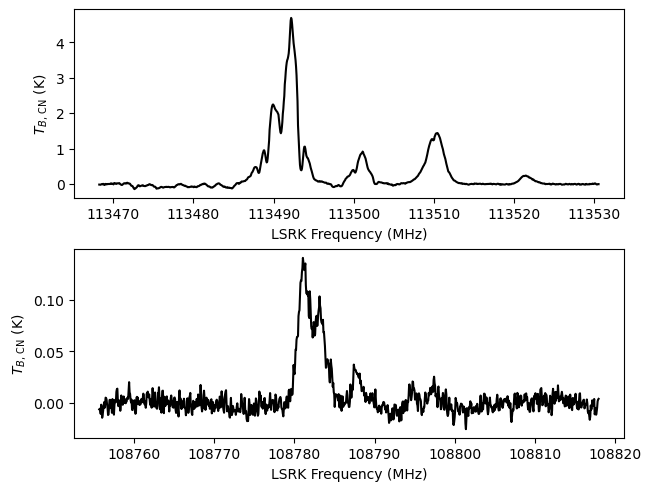

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
data_12CN = {"observation": obs_12CN}
data = {"12CN": obs_12CN, "13CN": obs_13CN}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Determine Number of Clouds

The CN data has much greater signal-to-noise, so let's use those data to constrain the number of "cloud" components. We suspect that non-thermal broadening is important and we do not have sufficient spectral resolution to resolve the thermal line widths. We also suspect that hyperfine anomalies impact the CN data, so we use `HFSAnomalyModel`. For this degenerate model, we can't constrain the optical depth or kinetic temperature, so we assume the emission is optically thin.

In [18]:
from bayes_cn_hfs import get_molecule_data

mol_data_12CN = get_molecule_data(
    "CN, v = 0, 1", # molecule name in JPLSpec
    vibrational_state = 0, # vibrational state number
    rot_state_lower = 0, # lower rotational state
)
weight_12CN = 12.0 + 14.0

In [19]:
from bayes_cn_hfs import HFSAnomalyModel
from bayes_spec import Optimize

max_n_clouds = 10
baseline_degree = 0
opt = Optimize(
    HFSAnomalyModel,
    data_12CN,
    mol_weight=weight_12CN, # molecular weight
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal FWHM prior (km/s)
    prior_log10_anomaly = 0.01, # width of hyperfine anomaly prior (dex)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s)
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # default baseline priors
    fix_tau_total = 0.1, # fix tau_total
    fix_log10_Tkin = 1.5, # fix log10_Tkin
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

## Approximate with Variational Inference

Since VI is relatively fast, let's sample all of the models just to get an idea of how many "cloud" components we're dealing with. We will inspect the BICs for each model.

In [20]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
opt.fit_all(**fit_kwargs)

Null hypothesis BIC = 9.837e+05
Approximating n_cloud = 1 posterior...


Output()

Finished [100%]: Average Loss = 1.3321e+05


Output()

n_cloud = 1 BIC = 2.132e+05

Approximating n_cloud = 2 posterior...


Output()

Finished [100%]: Average Loss = 1.1146e+05


Output()

n_cloud = 2 BIC = 1.467e+05

Approximating n_cloud = 3 posterior...


Output()

Finished [100%]: Average Loss = 1.0845e+05


Output()

n_cloud = 3 BIC = 1.411e+05

Approximating n_cloud = 4 posterior...


Output()

Interrupted at 51,167 [51%]: Average Loss = 3.1725e+05


Output()

n_cloud = 4 BIC = 1.489e+05

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 99500
Interrupted at 99,499 [99%]: Average Loss = 2.0846e+05


Output()

n_cloud = 5 BIC = 1.353e+05

Approximating n_cloud = 6 posterior...


Output()

Convergence achieved at 95200
Interrupted at 95,199 [95%]: Average Loss = 2.0459e+05


Output()

n_cloud = 6 BIC = 1.317e+05

Approximating n_cloud = 7 posterior...


Output()

Convergence achieved at 96100
Interrupted at 96,099 [96%]: Average Loss = 1.9517e+05


Output()

n_cloud = 7 BIC = 1.303e+05

Approximating n_cloud = 8 posterior...


Output()

Convergence achieved at 95300
Interrupted at 95,299 [95%]: Average Loss = 1.8986e+05


Output()

n_cloud = 8 BIC = 1.256e+05

Approximating n_cloud = 9 posterior...


Output()

Convergence achieved at 100000
Interrupted at 99,999 [99%]: Average Loss = 1.7933e+05


Output()

n_cloud = 9 BIC = 1.226e+05

Approximating n_cloud = 10 posterior...


Output()

Finished [100%]: Average Loss = 98,153


Output()

n_cloud = 10 BIC = 1.201e+05



In [21]:
n_clouds = np.arange(max_n_clouds + 1)
null_bic = opt.models[1].null_bic()
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics_vi):
    print(n_cloud, bic)

0 983688.523437288
1 213157.92076144443
2 146713.3429189338
3 141125.2183195776
4 148866.106384502
5 135343.37408821078
6 131728.39638987352
7 130347.89570396976
8 125648.81868264996
9 122634.79320652096
10 120068.13841948983


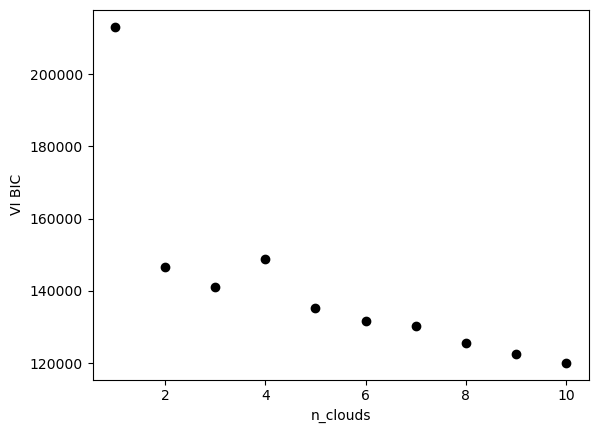

In [22]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics_vi[1:], 'ko')
ax.set_xlabel("n_clouds")
_ = ax.set_ylabel("VI BIC")

According to VI, the best model probably has `n_clouds = 8`. Let's sample each posterior with MCMC and judge how well the VI approximations are doing.

In [ ]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(fit_kwargs=fit_kwargs, sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 9.837e+05
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1.3321e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 39 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 2.133e+05

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1.1146e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 108 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.468e+05

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Finished [100%]: Average Loss = 1.0845e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 146 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.415e+05

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 99300
Interrupted at 99,299 [99%]: Average Loss = 2.1936e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 182 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 4 solution = 0 BIC = 1.382e+05

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 99500
Interrupted at 99,499 [99%]: Average Loss = 2.0846e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_observation_norm, velocity_norm, fwhm_nonthermal_norm, fwhm_L_norm, log10_anomaly_norm]


Output()

In [ ]:
null_bic_mcmc = opt.models[1].null_bic()
bics_mcmc = np.array([null_bic_mcmc] + [model.bic() for model in opt.models.values()])
for n_cloud, bic in zip(n_clouds, bics_mcmc):
    print(n_cloud, bic)

In [ ]:
fig, ax = plt.subplots()
ax.plot(n_clouds[1:], bics_vi[1:], 'ko', label="VI")
ax.plot(n_clouds[1:], bics_mcmc[1:], 'ro', label="MCMC")
ax.set_xlabel("n_clouds")
ax.legend(loc="best")
_ = ax.set_ylabel("BIC")

In [ ]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)

Let's also inspect the residuals.

Text(0, 0.5, '$T_{B,\\,\\rm CN}$ (K)')

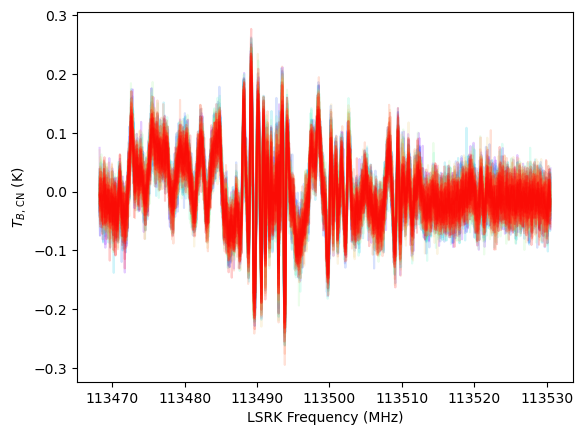

In [13]:
# Plot the residuals
fig, ax = plt.subplots()

color = iter(plt.cm.rainbow(np.linspace(0, 1, len(posterior.posterior_predictive.chain))))
for chain in posterior.posterior_predictive.chain:
    c = next(color)
    ax.plot(
        data["12CN"].spectral,
        posterior.posterior_predictive["observation"].sel(
            chain=chain, draw=slice(None, None, 1)
        ).T - data["12CN"].brightness[:, None],
        "-",
        color=c,
        alpha=0.2,
    )
ax.set_xlabel(data["12CN"].xlabel)
ax.set_ylabel(data["12CN"].ylabel)

In [14]:
print(f"Best model has n_clouds={opt.best_model.n_clouds}")
print(f"Best model has solutions={opt.best_model.solutions}")
pm.summary(opt.best_model.trace.solution_0)

Best model has n_clouds=6
Best model has solutions=[0]


/opt/conda/envs/bayes_cn_hfs-dev/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline_observation_norm[0],-0.425,0.001,-0.428,-0.422,0.000,0.000,464.0,374.0,1.01
velocity_norm[0],-1.575,0.019,-1.598,-1.539,0.002,0.001,183.0,558.0,1.02
velocity_norm[1],-2.688,0.007,-2.700,-2.676,0.000,0.000,310.0,930.0,1.01
velocity_norm[2],-1.630,0.015,-1.652,-1.603,0.001,0.001,152.0,630.0,1.02
velocity_norm[3],-0.510,0.005,-0.519,-0.499,0.000,0.000,163.0,76.0,1.02
velocity_norm[4],-1.072,0.013,-1.088,-1.048,0.001,0.001,187.0,604.0,1.02
velocity_norm[5],0.182,0.018,0.143,0.212,0.001,0.001,261.0,132.0,1.00
"log10_anomaly_norm[113123.3687, 0]",0.050,0.974,-1.746,1.862,0.044,0.031,508.0,229.0,1.00
"log10_anomaly_norm[113123.3687, 1]",-0.100,1.058,-1.989,1.750,0.060,0.045,315.0,231.0,1.02
"log10_anomaly_norm[113123.3687, 2]",0.050,0.968,-1.784,1.874,0.030,0.022,979.0,1366.0,1.01


## Model Definition

In [ ]:
from bayes_cn_hfs import CNRatioAnomalyModel

# Initialize and define the model
n_clouds = 6
baseline_degree = 3
model = CNRatioAnomalyModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [14.0, 0.5], # mean and width of log10(12CN N) prior (cm-2)
    prior_log10_tex = [1.0, 0.1], # mean and width of log10(T) prior (K)
    prior_fwhm = 2.0, # width of nonthermal FWHM prior (km/s)
    prior_velocity = [0.0, 5.0], # mean and width of velocity prior (km/s)
    prior_ratio_13C_12C = 0.01, # width of the 13C/12C prior
    prior_rms_12CN = 0.05, # width of the 12CN spectral rms prior (K)
    prior_rms_13CN = 0.05, # width of the 13CN spectral rms prior (K)
    prior_baseline_coeffs = {
        "12CN": [1.0, 1.0, 1.0, 0.5], # width of polynomial baseline coefficients prior
        "13CN": [1.0, 1.0, 1.0, 0.5],
    },
    prior_tex_12CN_anomaly = 1.0, # width of the 12CN Tex anomaly prior (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

## Variational Inference

In [ ]:
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)

In [ ]:
# posterior samples stored in model.trace.posterior
pm.summary(model.trace.posterior)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC

In [ ]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

In [ ]:
model.solve(kl_div_threshold=0.1)

In [ ]:
pm.summary(model.trace.solution_0)

In [ ]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)